# Looking for the subsurface chlorophyll A maximum
The data is a synthesis product that comes from here:
https://www.seanoe.org/data/00311/42182/

{BGC Sprof data files (2022-10-08 snapshot)}


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### establish regions and import mask

Text(0.5, 0.98, 'check that norm of colours works')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


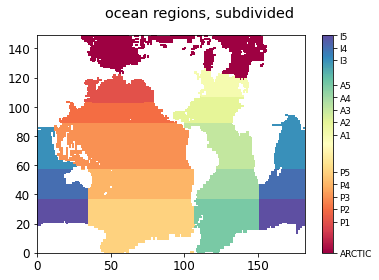

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


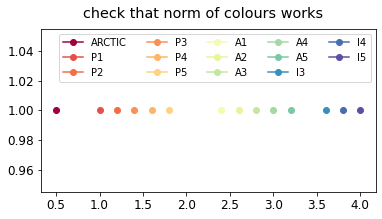

In [4]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('check that norm of colours works')

## primary extraction process description

    - set horse flag to True in cell below to run (horses run)
    - Load individual BGC argo profiles and check if they contain chlA
    - for each profile, get out CHLA_ADJUSTED and CHLA_ADJUSTED_QC
    - look only at CHLA_ADJUSTED where CHLA_ADJUSTED_QC is 1
    - find depth of subsurface chl max, store depth and identity of max
    - also check whether the depth of the SS chlmax is identical to the first measurement (for possibility of discarding later)
    - save table with these data as csv, then concatenate csv on identity of profile (which is float number concatenated with prof. number / 1000)

In [5]:
horse = False

In [6]:
sset = ['coriolis','kma','csiro','bodc', 'nmdis', 'incois', 'aoml', 'meds', 'csio', 'kordi', 'jma']

In [7]:
if horse:
    i = 0
    with_chl = []
    for i in range(0,len(sset)):
        w = glob.glob(f'/gpfs/data/greenocean/observations/202210-BgcArgoSprof/dac/{sset[i]}/*.nc')
        print(len(w))
        for r in range(0,len(w)):
            tw = xr.open_dataset(w[r])
            if 'CHLA' in tw.keys():
                with_chl.append(w[r])
    pickle.dump(with_chl, open("./pkls/BGCwithCHL.pkl", 'wb'))


In [8]:
verbose = False
if horse:

    BGClist = pickle.load(open('./pkls/BGCwithCHL.pkl', 'rb'))

    for i in range(0,len(BGClist)):
        t1 = time.time()
        print(f'{i}: extracting subsurface chlorophyll for {BGClist[i]}')
        w = xr.open_dataset(BGClist[i])
        #print(w)
        tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
        tplat = int(tplat[0])
        testnam = f'CHLMAX_{w.institution}_{tplat}.csv'
        print(f'to {testnam}')
        no_profs = (len(w['N_PROF']))

        funct_prof = []
        for k in range(0,no_profs):

            testchl_qc = w['CHLA_ADJUSTED_QC'][k,:].values.astype(float)
            tmin = np.nanmin(testchl_qc)
            if tmin <= 1.0:
                funct_prof.append(k)


        ## save lat, lon, y, x, region of ocean, date, loc of max
        floatno = np.zeros(len(funct_prof))
        lat = np.zeros(len(funct_prof))
        lon = np.zeros(len(funct_prof))
        mon = np.zeros(len(funct_prof))
        day = np.zeros(len(funct_prof))    
        year = np.zeros(len(funct_prof))
        chlmax = np.zeros(len(funct_prof))
        depth_chlmax= np.zeros(len(funct_prof))
        max_below_first_measurement = np.zeros(len(funct_prof))

        for k in range(0,len(funct_prof)):

            tp = funct_prof[k]

            testchl = w['CHLA_ADJUSTED'][tp,:].values.astype(float)
            testchl_qc = w['CHLA_ADJUSTED_QC'][tp,:].values.astype(float)
            testpres = w['PRES'][tp,:].values.astype(float)
            filt = (testchl_qc == 1.0)

            foran_chl = testchl[filt]
            foran_pres = testpres[filt]

            chlmax[k] = (np.nanmax(foran_chl)) #max fluorescence 
            dchlmax = ((np.where(foran_chl == chlmax[k]))[0][0])
            depth_chlmax[k] = foran_pres[dchlmax]
            firstmes = (np.nanmin(testpres[filt]))

            if depth_chlmax[k] > firstmes:
                max_below_first_measurement[k] = 1

            #place in spacetime, number of float, number of profiles            
            lat[k] = w['LATITUDE'][tp].values.astype(float)
            lon[k] = w['LONGITUDE'][tp].values.astype(float)
            testjuld = pd.to_datetime(w['JULD'][tp].values)
            mon[k] = testjuld.month
            day[k] = testjuld.day
            year[k] = testjuld.year
            floatno[k] = tplat + tp/1000



            if verbose:
                print(f'{lat[k]},{lon[k]},{mon[k]},{day[k]},{year[k]}, maxchl {chlmax[k]}, loc = {depth_chlmax[k]}, float = {floatno[k]}')
                plt.figure()
                plt.plot(testchl,-testpres)
                plt.plot(chlmax[k],-depth_chlmax[k],'r*')

        df = pd.DataFrame([floatno,lat,lon,mon,day,year,chlmax,depth_chlmax,max_below_first_measurement]).T
            # df = df.sort_values(by = tYEAR)
        df.columns = ['profno','lat','lon','mon','day','year','chlmax','depth_chlmax','max_below_first_measurement']
        df.wheremade = 'evalOutput/BGC_subsurfacechla.ipynb'
        df.to_csv(f'./argo_processed/{testnam}')

        t2 = time.time()        
        print(t2-t1)
        print()


## short demo of peak finding alg. on several individual profiles

0: extracting subsurface chlorophyll for /gpfs/data/greenocean/observations/202210-BgcArgoSprof/dac/coriolis/6902907_Sprof.nc
to CHLMAX_CORIOLIS_6902907.csv
-7.989143333333333,-140.47197166666666,1.0,31.0,2019.0, maxchl 0.32850000262260437, loc = 83.5999984741211, float = 6902907.109
-9.164051666666667,-140.98777,8.0,17.0,2019.0, maxchl 1.3213000297546387, loc = 89.19999694824219, float = 6902907.185
-8.902353333333334,-140.906755,9.0,16.0,2019.0, maxchl 0.5547999739646912, loc = 56.79999923706055, float = 6902907.191


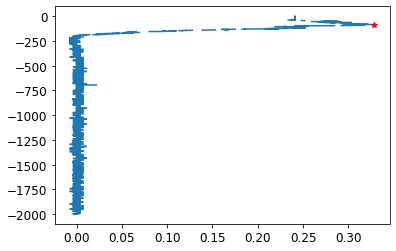

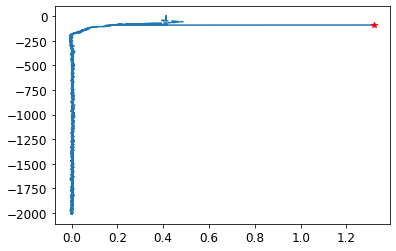

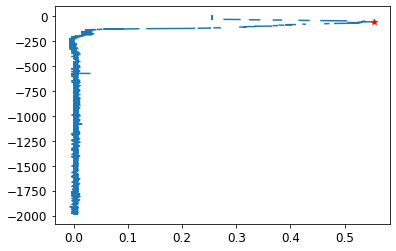

In [9]:
verbose = True


BGClist = pickle.load(open('./pkls/BGCwithCHL.pkl', 'rb'))

for i in range(0,1):#len(BGClist)):
    t1 = time.time()
    print(f'{i}: extracting subsurface chlorophyll for {BGClist[i]}')
    w = xr.open_dataset(BGClist[i])
    #print(w)
    tplat = (np.unique(w['PLATFORM_NUMBER']).astype(float))
    tplat = int(tplat[0])
    testnam = f'CHLMAX_{w.institution}_{tplat}.csv'
    print(f'to {testnam}')
    no_profs = (len(w['N_PROF']))

    funct_prof = []
    for k in range(0,no_profs):

        testchl_qc = w['CHLA_ADJUSTED_QC'][k,:].values.astype(float)
        tmin = np.nanmin(testchl_qc)
        if tmin <= 1.0:
            funct_prof.append(k)


    ## save lat, lon, y, x, region of ocean, date, loc of max
    floatno = np.zeros(len(funct_prof))
    lat = np.zeros(len(funct_prof))
    lon = np.zeros(len(funct_prof))
    mon = np.zeros(len(funct_prof))
    day = np.zeros(len(funct_prof))    
    year = np.zeros(len(funct_prof))
    chlmax = np.zeros(len(funct_prof))
    depth_chlmax= np.zeros(len(funct_prof))
    max_below_first_measurement = np.zeros(len(funct_prof))

    for k in range(0,3):#len(funct_prof)):

        tp = funct_prof[k]

        testchl = w['CHLA_ADJUSTED'][tp,:].values.astype(float)
        testchl_qc = w['CHLA_ADJUSTED_QC'][tp,:].values.astype(float)
        testpres = w['PRES'][tp,:].values.astype(float)
        filt = (testchl_qc == 1.0)

        foran_chl = testchl[filt]
        foran_pres = testpres[filt]

        chlmax[k] = (np.nanmax(foran_chl)) #max fluorescence 
        dchlmax = ((np.where(foran_chl == chlmax[k]))[0][0])
        depth_chlmax[k] = foran_pres[dchlmax]
        firstmes = (np.nanmin(testpres[filt]))

        if depth_chlmax[k] > firstmes:
            max_below_first_measurement[k] = 1

        #place in spacetime, number of float, number of profiles            
        lat[k] = w['LATITUDE'][tp].values.astype(float)
        lon[k] = w['LONGITUDE'][tp].values.astype(float)
        testjuld = pd.to_datetime(w['JULD'][tp].values)
        mon[k] = testjuld.month
        day[k] = testjuld.day
        year[k] = testjuld.year
        floatno[k] = tplat + tp/1000



        if verbose:
            print(f'{lat[k]},{lon[k]},{mon[k]},{day[k]},{year[k]}, maxchl {chlmax[k]}, loc = {depth_chlmax[k]}, float = {floatno[k]}')
            plt.figure()
            plt.plot(testchl,-testpres)
            plt.plot(chlmax[k],-depth_chlmax[k],'r*')




- concatenate chlorophyll profiles into a single file, called ./argo_processed/concat_chlmax.csv
- find model y, x in findYX_forchlx.py
- concatenate Y,X with the rest of the dataframe, get regions as seen above, save whole thing again

In [10]:
## concatenate chlorophylls 
if horse:
    w = glob.glob('./argo_processed/CHLMAX_*')
    df1 = pd.read_csv(w[0])
    df2 = pd.read_csv(w[1])

    # print(df1)
    # print(df2)
    dfs = []
    # df = pd.concat([df1, df2])
    for i in range(0,len(w)):
        dfs.append(pd.read_csv(w[i]))

    masterdf = pd.concat(dfs)
    masterdf.to_csv(f'./argo_processed/concat_chlmax.csv')

In [11]:
if horse:
    masterdf = pd.read_csv('./argo_processed/concat_chlmax.csv')
    yx1 = pd.read_csv(f'./argo_processed/chl_yx_0_30000.csv')
    yx2 = pd.read_csv(f'./argo_processed/chl_yx_30000_end.csv')

    Y = np.zeros_like(lat)
    X = np.zeros_like(lat)

    Y[0:30000] = yx1['Y'][0:30000]
    X[0:30000] = yx1['X'][0:30000]
    Y[30000:68000] = yx2['Y'][30000:68000]
    X[30000:68000] = yx2['X'][30000:68000]

    masterdf['Y'] = Y
    masterdf['X'] = X
    if horse:
        tREG = np.zeros_like(Y)

        for i in range(0,len(X)):
            tREG[i] = maskno[int(Y[i]), int(X[i])]
    masterdf['REG'] = tREG        
    masterdf.to_csv(f'./argo_processed/concat_chlmax.csv')

# cleaned dataset look

In [32]:
chlmax = pd.read_csv(f'./argo_processed/concat_chlmax.csv')
chlmax.columns
chlmax.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'], axis = 1)


,profno,lat,lon,mon,day,year,chlmax,depth_chlmax,max_below_first_measurement,Y,X,REG
0,5904984.000,-61.994000,-68.697000,12.0,29.0,2016.0,0.860783,900.000000,1.0,25.0,107.0,3.2
1,5904984.001,-62.045000,-68.094000,1.0,8.0,2017.0,0.382990,62.000000,1.0,25.0,107.0,3.2
2,5904984.002,-61.866000,-68.069000,1.0,18.0,2017.0,0.352350,68.000000,1.0,25.0,107.0,3.2
3,5904984.003,-61.578000,-67.709000,1.0,28.0,2017.0,0.626195,72.000000,1.0,26.0,107.0,3.2
4,5904984.004,-61.266000,-67.073000,2.0,7.0,2017.0,1.086753,50.000000,1.0,26.0,107.0,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...
67892,3901531.338,11.233138,-108.890273,6.0,13.0,2021.0,0.648000,44.200001,1.0,86.0,87.0,1.4
67893,3901531.340,11.263890,-109.027103,6.0,23.0,2021.0,0.637500,41.200001,1.0,86.0,86.0,1.4
67894,3901531.341,11.281737,-109.121147,6.0,28.0,2021.0,0.612000,48.900002,1.0,86.0,86.0,1.4
67895,3901531.342,11.329472,-109.191033,7.0,3.0,2021.0,0.678000,40.299999,1.0,86.0,86.0,1.4


In [16]:
def custhist(tdat, nbins, start, end, tweights = None):
    #bins = 25
    hist_met_vflx, bins = np.histogram(np.ravel(tdat), bins=nbins,\
                                 range = [start, end], weights=tweights)

    bin_cent = bins + (bins[1]-bins[0])/2
    tot_count = np.sum(hist_met_vflx)

    
    binsback = bins
    bin_cent = bin_cent[0:nbins]
    histback = hist_met_vflx/tot_count
    
    return binsback, bin_cent, histback

- subdivide pandas dataset and check number of obs. (turn on bear flag to run)

In [31]:
bear = False
if bear:
    true_subsurface = ((chlmax['max_below_first_measurement'] == 1.0) & (chlmax['depth_chlmax'] < 5))
    chlmax['depth_chlmax']

    winter_chl = (chlmax.loc[true_subsurface,['depth_chlmax']])
    display(winter_chl)
    winter_chl = (chlmax.loc[true_subsurface])
    display(winter_chl)

    chlmin_threshold = (chlmax['chlmax'] > 0.5)
    true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
    djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
    mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
    jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
    son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))

    for r in range(0,len(regs)):
        regnum = regdict[regs[r]]['number']
        print(f'{regs[r]},{regnum}')
        regcond = (chlmax['REG'] == regnum)
        djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
        mam_chl = (chlmax.loc[(mam & regcond  & true_subsurface & chlmin_threshold),['depth_chlmax']])
        jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
        son_chl = (chlmax.loc[(son & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
        print(djf_chl['depth_chlmax'].size)
        print(mam_chl['depth_chlmax'].size)
        print(jja_chl['depth_chlmax'].size)
        print(son_chl['depth_chlmax'].size)

        print()

Text(0.5, 0.96, 'histograms of depth of subsurface chl. max (m), with threshold for detectable chl max considered 1 mg/m3 \n min number of obs to calculate histogram = 10, no. obs shown in legend')

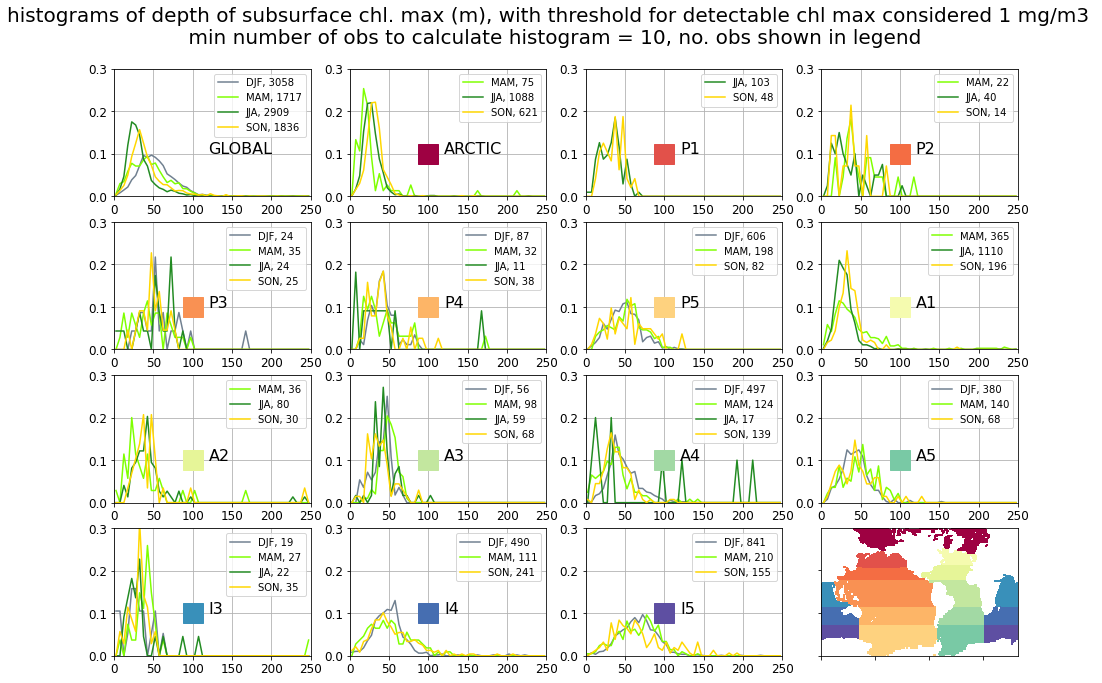

In [29]:
tmax = 1
stit = f'histograms of depth of subsurface chl. max (m), with threshold for detectable chl max considered {tmax} mg/m3 \n min number of obs to calculate histogram = 10, no. obs shown in legend'

fact = 0.9
seasons = ['DJF', 'MAM', 'JJA', 'SON']
seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
fig, axs = plt.subplots(4,4, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

nbins = 50
start = 0
end = 250

chlmin_threshold = (chlmax['chlmax'] > tmax)
true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))


djf_chl = (chlmax.loc[(djf & true_subsurface & chlmin_threshold),['depth_chlmax']])
mam_chl = (chlmax.loc[(mam   & true_subsurface & chlmin_threshold),['depth_chlmax']])
jja_chl = (chlmax.loc[(jja  & true_subsurface & chlmin_threshold),['depth_chlmax']])
son_chl = (chlmax.loc[(son  & true_subsurface & chlmin_threshold),['depth_chlmax']])

seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
for s in range(0,4):
    tseas = seaschl[s]
    if tseas['depth_chlmax'].size > 10:
        nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
        tsize = tseas['depth_chlmax'].size
        axs[0].plot(bin_cent,histback, color = seascol[s], label = f'{seasons[s]}, {tsize}')
axs[0].legend(loc = 'best', fontsize = 10)
axs[0].text(120,0.1,'GLOBAL', color = 'k', fontsize = 16)

for r in range(0,len(regs)):
    regnum = regdict[regs[r]]['number']
    #print(f'{regs[r]},{regnum}')
    regcond = (chlmax['REG'] == regnum)
    djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    mam_chl = (chlmax.loc[(mam & regcond  & true_subsurface & chlmin_threshold),['depth_chlmax']])
    jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    son_chl = (chlmax.loc[(son & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    
    seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
    for s in range(0,4):
        tseas = seaschl[s]
        if tseas['depth_chlmax'].size > 10:
            nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
            tsize = tseas['depth_chlmax'].size
            axs[r+1].plot(bin_cent,histback, color = seascol[s], label = f'{seasons[s]}, {tsize}')
    axs[r+1].legend(loc = 'best', fontsize = 10)

axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
axs[15].set_xticklabels([])
axs[15].set_yticklabels([])

# axs[0].text(2100,-560,'GLOBAL', color = 'k', fontsize = 16)


for i in range(0,len(regs)+1):
    axs[i].set_xlim([0,250])
    axs[i].set_ylim([0,0.3])
    axs[i].grid()
for i in range(0,len(regs)):
    axs[i+1].plot(100,0.1,marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
    axs[i+1].text(120,0.1,regs[i], color = 'k', fontsize = 16)

plt.suptitle(stit, fontsize = 20, y = 0.96)

Text(0.5, 0.96, 'histograms of depth of subsurface chl. max (m), with threshold for detectable chl max considered 1 mg/m3 \n min number of obs to calculate histogram = 10, no. obs shown in legend')

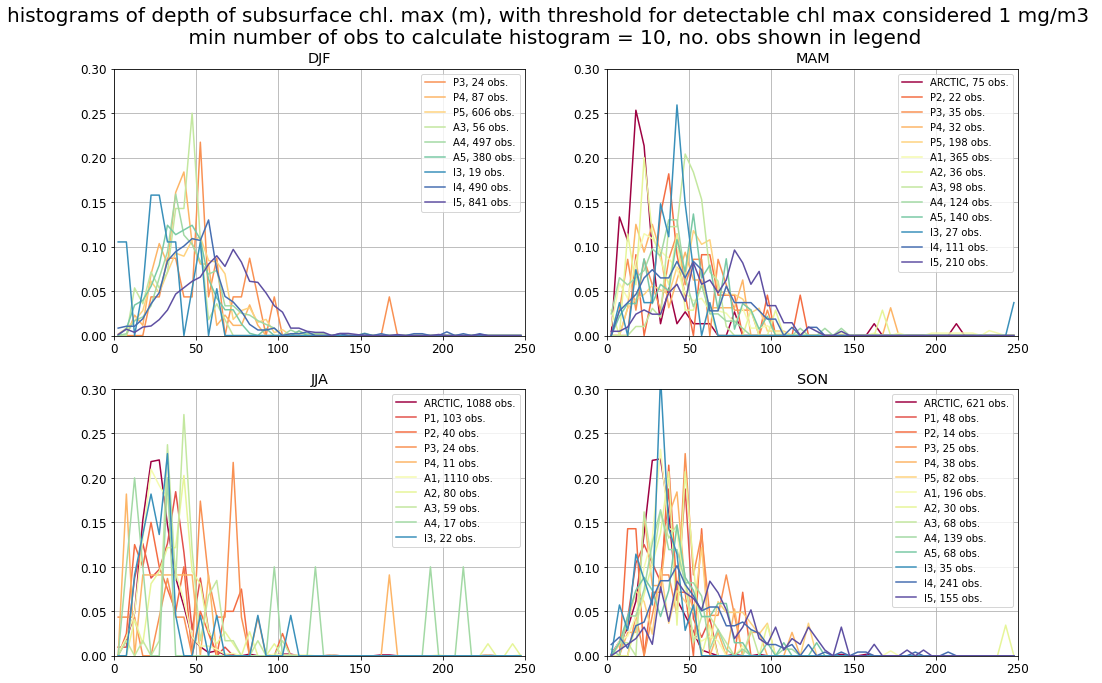

In [39]:
tmax = 1
stit = f'histograms of depth of subsurface chl. max (m), with threshold for detectable chl max considered {tmax} mg/m3 \n min number of obs to calculate histogram = 10, no. obs shown in legend'

fact = 0.9
seasons = ['DJF', 'MAM', 'JJA', 'SON']
seascol = ['slategrey', 'chartreuse', 'forestgreen', 'gold']
fig, axs = plt.subplots(2,2, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

nbins = 50
start = 0
end = 250

chlmin_threshold = (chlmax['chlmax'] > tmax)
true_subsurface = (chlmax['max_below_first_measurement'] == 1.0)
djf = ((chlmax['mon']>=12) | (chlmax['mon']<=2))
mam = ((chlmax['mon']>=3) & (chlmax['mon']<=5))
jja = ((chlmax['mon']>=6) & (chlmax['mon']<=8))
son = ((chlmax['mon']>=9) & (chlmax['mon']<=11))


# djf_chl = (chlmax.loc[(djf & true_subsurface & chlmin_threshold),['depth_chlmax']])
# mam_chl = (chlmax.loc[(mam   & true_subsurface & chlmin_threshold),['depth_chlmax']])
# jja_chl = (chlmax.loc[(jja  & true_subsurface & chlmin_threshold),['depth_chlmax']])
# son_chl = (chlmax.loc[(son  & true_subsurface & chlmin_threshold),['depth_chlmax']])

# seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
# for s in range(0,4):
#     tseas = seaschl[s]
#     if tseas['depth_chlmax'].size > 10:
#         nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
#         tsize = tseas['depth_chlmax'].size
#         axs[0].plot(bin_cent,histback, color = seascol[s], label = f'{seasons[s]}, {tsize}')
# axs[0].legend(loc = 'best', fontsize = 10)
# axs[0].text(120,0.1,'GLOBAL', color = 'k', fontsize = 16)

for r in range(0,len(regs)):
    regnum = regdict[regs[r]]['number']
    #print(f'{regs[r]},{regnum}')
    regcond = (chlmax['REG'] == regnum)
    djf_chl = (chlmax.loc[(djf &  regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    mam_chl = (chlmax.loc[(mam & regcond  & true_subsurface & chlmin_threshold),['depth_chlmax']])
    jja_chl = (chlmax.loc[(jja & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    son_chl = (chlmax.loc[(son & regcond & true_subsurface & chlmin_threshold),['depth_chlmax']])
    
    seaschl = [djf_chl,mam_chl, jja_chl, son_chl]
    for s in range(0,4):
        tseas = seaschl[s]
        if tseas['depth_chlmax'].size > 10:
            nsback, bin_cent, histback = custhist(tseas['depth_chlmax'], nbins, start, end)
            tsize = tseas['depth_chlmax'].size
            axs[s].plot(bin_cent,histback, color = regdict[regs[r]]['colour'], label = f'{regs[r]}, {tsize} obs.')


# axs[15].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
# axs[15].set_xticklabels([])
# axs[15].set_yticklabels([])

# # axs[0].text(2100,-560,'GLOBAL', color = 'k', fontsize = 16)


for i in range(0,4):
    axs[i].set_xlim([0,250])
    axs[i].set_ylim([0,0.3])
    axs[i].grid()
    axs[i].set_title(seasons[i])
    axs[i].legend(loc = 'best', fontsize = 10)
# for i in range(0,len(regs)):
#     axs[i+1].plot(100,0.1,marker = "s", color = regdict[regs[i]]['colour'], markersize = 20)
#     axs[i+1].text(120,0.1,regs[i], color = 'k', fontsize = 16)

plt.suptitle(stit, fontsize = 20, y = 0.96)